In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
from utils import parse_points3D, parse_cameras, parse_images, plot3D, remove_outliers, gen_video
from ransac import get_inplane_point_idx, ransac
from rigid import translate, get_vector_normal, get_rotation_matrix, rotate
from objects import get_combinations, build_3D_box, build_3D_table
from projection import forward_projection, calc_depth, order_by_depth

In [2]:
points3D_txt = './home/points3D.txt'
data = parse_points3D(points3D_txt)
print(data.shape)

cameras_txt = './home/cameras.txt'
cameras = parse_cameras(cameras_txt)
print(cameras[1])

images_txt = './home/images.txt'
images = parse_images(images_txt)
# print(images)
print({k:v for k,v in images[1].items()})

(30624, 3)
{'MODEL': 'SIMPLE_RADIAL', 'WIDTH': 1920, 'HEIGHT': 1080, 'PARAMS': [1855.42, 960.0, 540.0, 0.00782192]}
{'QW': 0.995842, 'QX': -0.0167632, 'QY': -0.080855, 'QZ': -0.0384821, 'TX': 3.70913, 'TY': -1.19895, 'TZ': 1.91089, 'CAMERA_ID': 1, 'NAME': 'frame0.png'}


### Remove extreme outliers

In [3]:
data = remove_outliers(data, 4)
print(data.shape)

# outlier points: (79, 3)
# inlier points: (30545, 3)
(30545, 3)


### Run RANSAC to find dominant plane

In [4]:
sample_size = 3
num_iters = 20
threshold_inlier = 0.01
num_points = 1000
best_model, best_count = ransac(data, sample_size, num_iters, threshold_inlier, num_points)
print('best fit:', best_model, best_count)

iter 0: model param [ 0.02140409 -0.06232054 -0.12354063  0.99014935], in plane point count 1216
iter 1: model param [ 0.04383438 -0.06520521 -0.10256903  0.99161808], in plane point count 2792
iter 2: model param [-0.61486536  0.55953379 -0.12538368 -0.54142539], in plane point count 113
iter 3: model param [-0.18158915  0.68189491 -0.15240636 -0.69196606], in plane point count 163
iter 4: model param [ 0.05168815 -0.09327634 -0.0994724   0.98930941], in plane point count 2408
iter 5: model param [-0.01498298 -0.02871455 -0.12880927  0.99114033], in plane point count 1475
iter 6: model param [-0.01900651 -0.10481392 -0.10787778  0.98844078], in plane point count 2441
iter 7: model param [-0.09142883 -0.35946533 -0.06978818  0.92604268], in plane point count 550
iter 8: model param [-0.00248739 -0.13518234 -0.09308387  0.98643547], in plane point count 18938
iter 9: model param [ 0.04838811 -0.1479259  -0.11762351  0.98078603], in plane point count 377
iter 10: model param [-0.00246535

In [5]:
inplane_point_idx = get_inplane_point_idx(best_model, data, threshold_inlier)
inplane_points = data[inplane_point_idx, :]
print('# inplane points:', inplane_points.shape)

mask = np.ones(len(data), np.bool)
mask[inplane_point_idx] = 0
outplane_points = data[mask]
print('# outplane points:', outplane_points.shape)

# inplane points: (18967, 3)
# outplane points: (11578, 3)


### XYZ coordinates

<IPython.core.display.Javascript object>


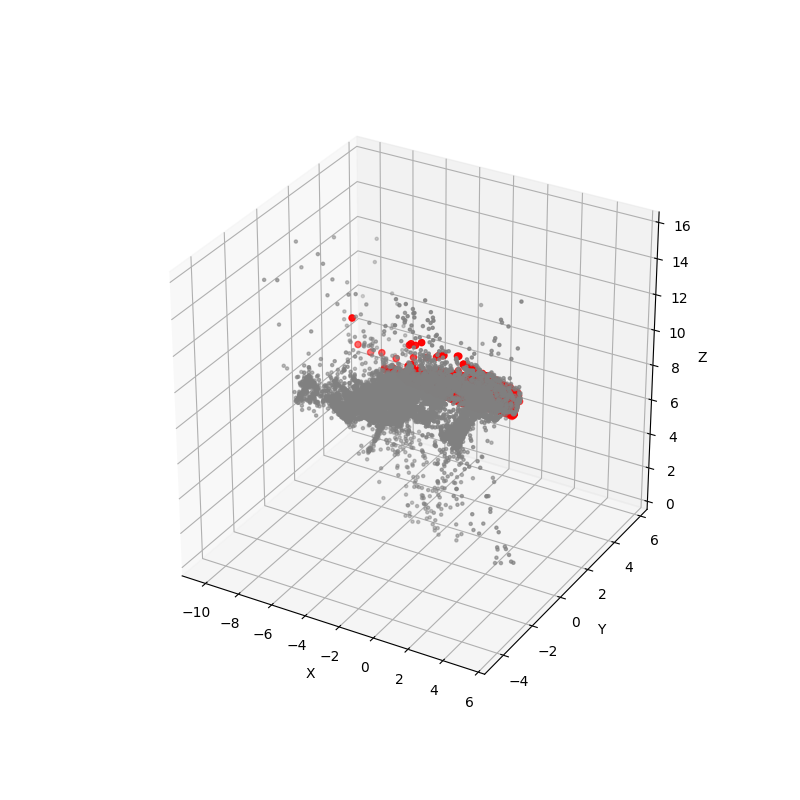

In [6]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_plane=False)

<IPython.core.display.Javascript object>


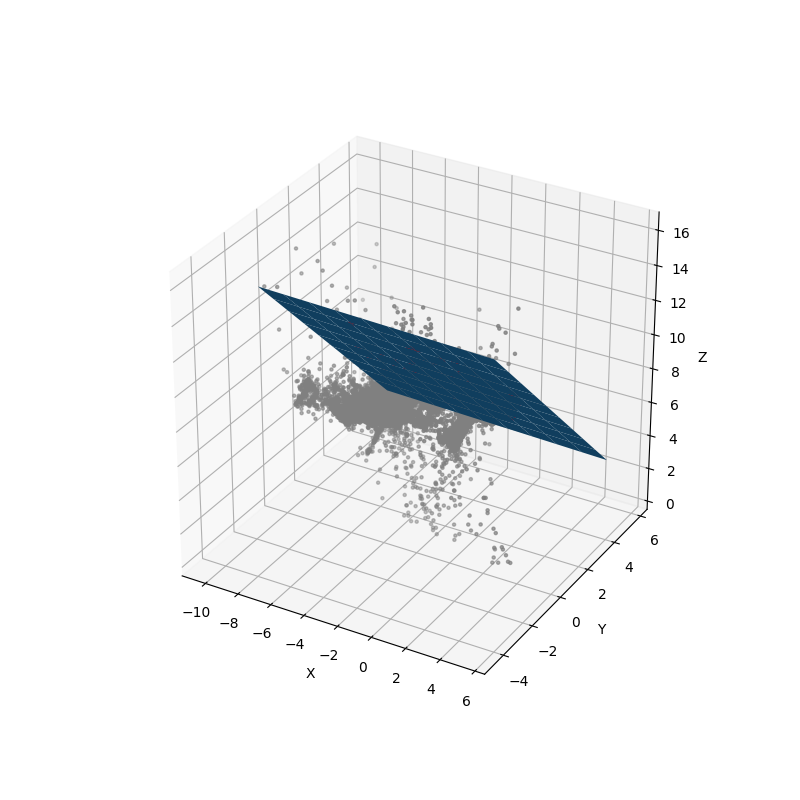

In [7]:
%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_plane=True, model=best_model)

### Compute rotation matrix

In [8]:
center_XYZ = np.mean(inplane_points, axis=0)
center_XYZ = center_XYZ.reshape(1, 3)
inplane_points_centered = translate(inplane_points, -center_XYZ)
outplane_points_centered = translate(outplane_points, -center_XYZ)

In [9]:
normal_XYZ = get_vector_normal(best_model)
normal_xyz = np.array([0, 0, 1])

In [10]:
# R_xyz2XYZ = get_rotation_matrix(normal_xyz, normal_XYZ)
R_XYZ2xyz = get_rotation_matrix(normal_XYZ, normal_xyz)

In [11]:
inplane_points_local = rotate(inplane_points_centered, R_XYZ2xyz)
outplane_points_local = rotate(outplane_points_centered, R_XYZ2xyz)

### Local xyz coordinates

<IPython.core.display.Javascript object>


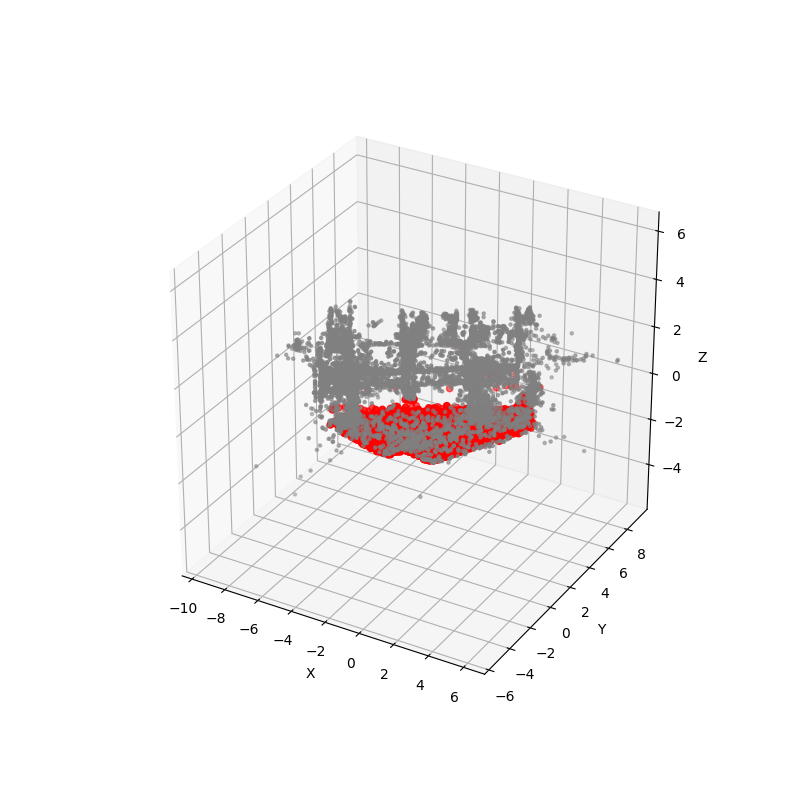

In [12]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_plane=False)

<IPython.core.display.Javascript object>


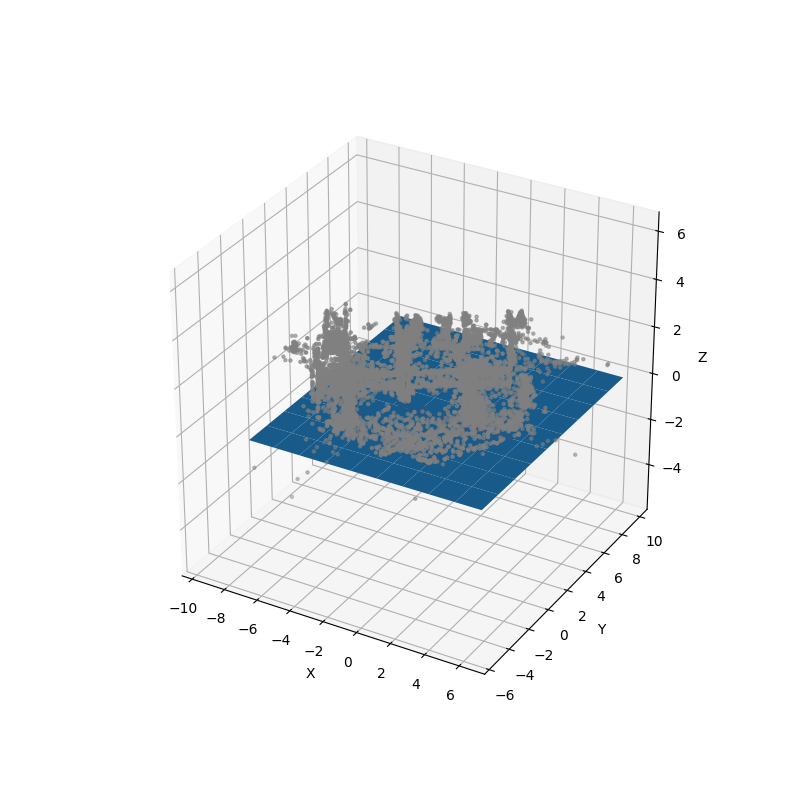

In [13]:
%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_plane=True, model=np.array([0, 0, 1, 0]))

### Put a 3D box or table in local xyz coordinates

In [14]:
obj = 'table' # either 'box' or 'table'

<IPython.core.display.Javascript object>


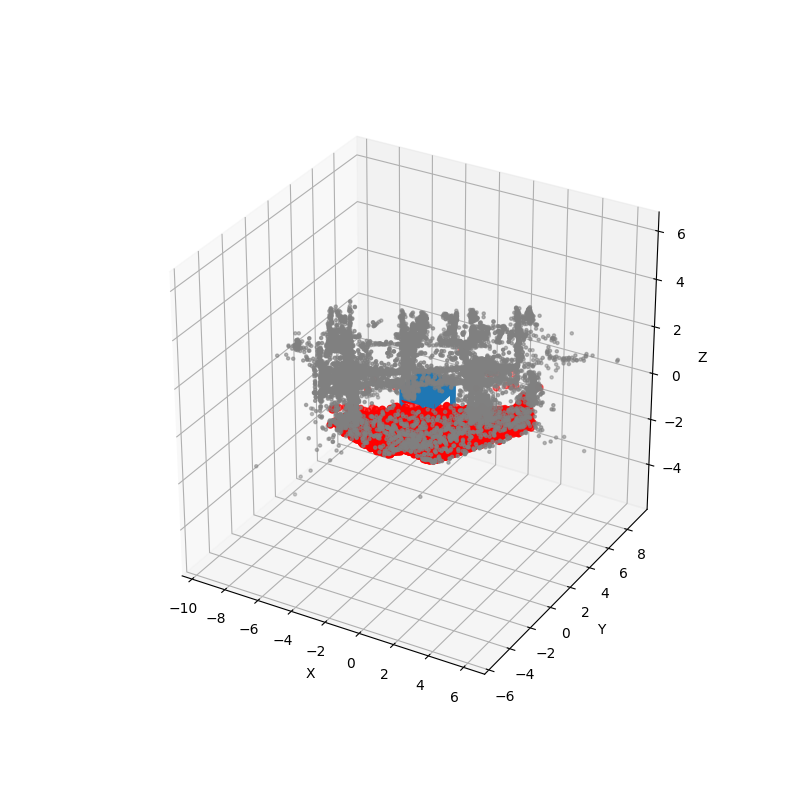

In [15]:
if obj == 'box':
    dimx, dimy, dimz = 2, 2, 1 # box dimension along axis
    corners_local = build_3D_box(dimx, dimy, dimz)
elif obj == 'table':
    dimx, dimy, legheight, topheight = 2, 2, 1.5, 0.5
    corners_local = build_3D_table(dimx, dimy, legheight, topheight)
else:
    print('wrong object specified')
combinations = get_combinations(len(corners_local), obj)

%matplotlib notebook
plot3D(inplane_points_local, outplane_points_local, plot_box=(obj=='box'), plot_table=(obj=='table'), corners=corners_local, combinations=combinations)

### Convert local 3D box or table back to scene XYZ coordinates

corners shape: (36, 3)


<IPython.core.display.Javascript object>


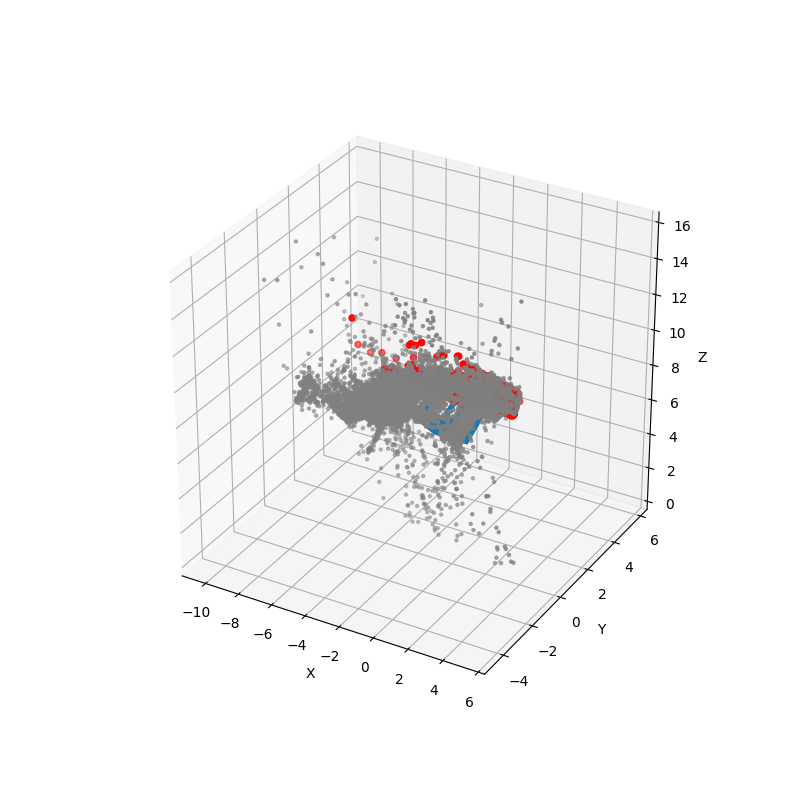

In [16]:
R_xyz2XYZ = get_rotation_matrix(normal_xyz, normal_XYZ)
corners = rotate(corners_local, R_xyz2XYZ)
corners = translate(corners, center_XYZ)
print('corners shape:', corners.shape)

%matplotlib notebook
plot3D(inplane_points, outplane_points, plot_box=(obj=='box'), plot_table=(obj=='table'), corners=corners, combinations=combinations)

### Check world -> image projection

In [17]:
# use 1st camera model and pose of 1st image
uv, _ = forward_projection(data, cameras[1], images[1])
# remove key points outside of image plane
WIDTH = cameras[1]['WIDTH']
HEIGHT = cameras[1]['HEIGHT']
uv_trimmed = []
for u, v in uv:
    if 0 <= u < WIDTH and 0 <= v < HEIGHT:
        uv_trimmed.append([u, v])
uv_trimmed = np.array(uv_trimmed)

<IPython.core.display.Javascript object>


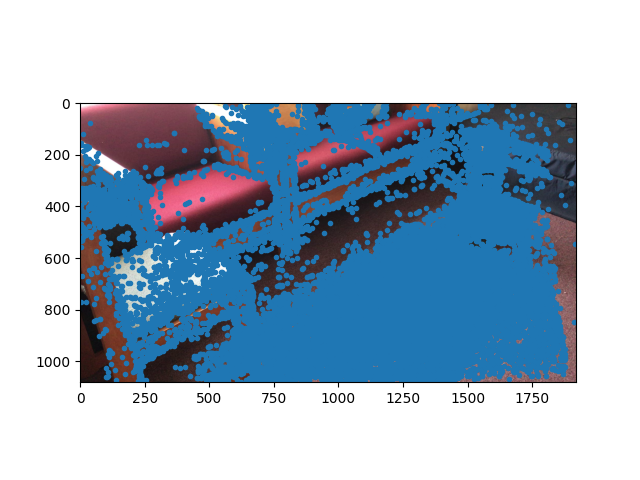

In [18]:
img = cv2.imread('./home/frames/frame0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.scatter(uv_trimmed[:, 0], uv_trimmed[:, 1], marker='.')
plt.show()

## Put virtual box on image

In [19]:
num_imgs = len(images)
i = 1 # index starts from 1
uv, depths = forward_projection(corners, cameras[1], images[i], calc_depth)
print('uv shape:', uv.shape)

uv shape: (36, 2)


<IPython.core.display.Javascript object>


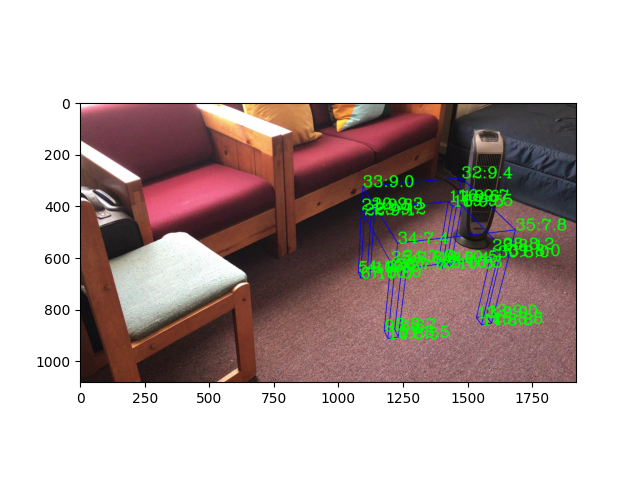

In [20]:
img = cv2.imread('./home/frames/frame0.png')
for comb in combinations:
    vertices = uv[comb, :]
    p1, p2, p3, p4 = vertices
    cv2.line(img, tuple(p1), tuple(p2), (255,0,0), 2)
    cv2.line(img, tuple(p2), tuple(p3), (255,0,0), 2)
    cv2.line(img, tuple(p3), tuple(p4), (255,0,0), 2)
    cv2.line(img, tuple(p4), tuple(p1), (255,0,0), 2)
for i in range(len(uv)):
    u, v = uv[i]
    d = depths[i]
    cv2.putText(img,'{}:{:.1f}'.format(i,d),(u,v),cv2.FONT_HERSHEY_COMPLEX,2,(0,255,0),3)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

#### plot surfaces ordered by depth

<IPython.core.display.Javascript object>


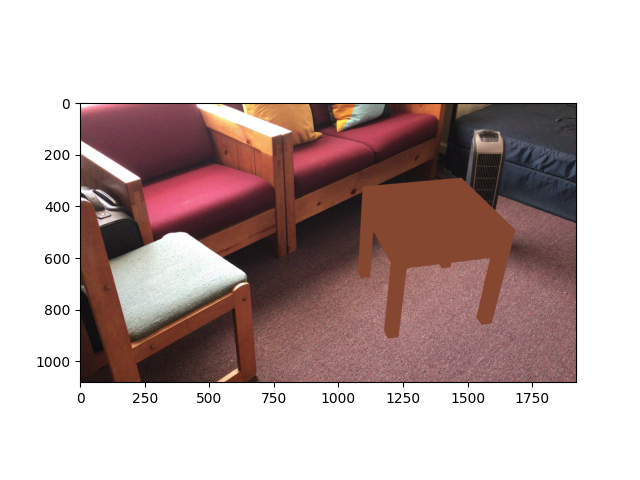

In [26]:
img = cv2.imread('./home/frames/frame0.png')
new_combinations = order_by_depth(combinations, depths)
for comb in new_combinations:
    vertices = uv[comb, :]
    cv2.fillPoly(img, [vertices], color=(49,71,134))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### Process all images and generate a video

In [29]:
frame_dir = './home/frames'
result_dir = './home/frames{}'.format(obj)
os.makedirs(result_dir, exist_ok=True)

num_imgs = len(images)
for i in range(1, num_imgs+1):
    uv, depths = forward_projection(corners, cameras[1], images[i], calc_depth)
    name = images[i]['NAME']
    name_ori = os.path.join(frame_dir, name)
    
    img = cv2.imread(name_ori)
    new_combinations = order_by_depth(combinations, depths)
    for comb in new_combinations:
        vertices = uv[comb, :]
        cv2.fillPoly(img, [vertices], color=(49,71,134))
    
    name_aug = os.path.join(result_dir, name)
    cv2.imwrite(name_aug, img)

In [30]:
video_name = './home/home{}.mov'.format(obj)
gen_video(result_dir, video_name)